# Задача: Отобразить высокомерные данные $X ∈ ℝ^D$ в низкомерное пространство $Y ∈ ℝ^d (d=2,3)$ так, чтобы сохранить структуру соседства.

    1. Вероятностная постановка задачи


Задача: Отобразить высокомерные данные X ∈ ℝ^D в низкомерное пространство Y ∈ ℝ^d (d=2,3)
так, чтобы сохранить структуру соседства.


        - Вероятности в исходном пространстве

Гауссово ядро для измерения сходства:

$
p_{j|i} = exp(-||x_i - x_j||^2 / (2σ_i^2)) / Σ_{k≠i} exp(-||x_i - x_k||^2 / (2σ_i^2))$

Симметризация вероятностей:

$
p_{ij} = (p_{j|i} + p_{i|j}) / (2n)$

Перплексия (perplexity) как гиперпараметр:

$
Perp(P_i) = 2^{H(P_i)}, $

где $H(P_i) = -Σ_j p_{j|i} log₂ p_{j|i}$

        - Вероятности в целевом пространстве

Распределение Стьюдента с одной степенью свободы:

$
q_{ij} = (1 + ||y_i - y_j||^2)^{-1} / Σ_{k≠l} (1 + ||y_k - y_l||^2)^{-1}$

Преимущества t-распределения:

       * Тяжелые хвосты

       * Устойчивость к проклятию размерности

       * Улучшенное разделение кластеров

       * Функция стоимости (KL-дивергенция)

$C(Y) = KL(P||Q) = Σ_i Σ_j p_{ij} log(p_{ij} / q_{ij})$

    2. Оптимизация функции стоимости

        2.1. Градиент функции стоимости

$∂C/∂y_i = 4 Σ_j (p_{ij} - q_{ij})(y_i - y_j)(1 + ||y_i - y_j||^2)^{-1}$

       2.2. Методы оптимизации

Градиентный спуск с моментумом:

$Y^{(t)} = Y^{(t-1)} + η ∂C/∂Y + α(t)(Y^{(t-1)} - Y^{(t-2)})$


Раннее преувеличение (early exaggeration):


$p_{ij} ← p_{ij} × 4 (первые 100 итераций)$


Адаптивное обучение (adaptive learning rate)

        2.3. Сложности оптимизации

            - Невыпуклость функции стоимости

            - Локальные минимумы

            - Чувствительность к начальной инициализации

            - Вычислительная сложность O(n²)

Импорт библиотек

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Задание

1. Провести исследование влияния гиперпараметров на результаты кластеризации с T-SNE
2. Сравнить с PCA
   
Использовать 2 датасета - стандартного типа Ирис или Цифры, и своего. Не забываем про нормировку и eda в целом

In [16]:
path = "Dry_Bean_Dataset.csv"

df = pd.read_csv(path)
df.head()

Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0  28395    610.291       208.178117       173.888747      1.197191   
1  28734    638.018       200.524796       182.734419      1.097356   
2  29380    624.110       212.826130       175.931143      1.209713   
3  30008    645.884       210.557999       182.516516      1.153638   
4  30140    620.134       201.847882       190.279279      1.060798   

   Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  roundness  \
0      0.549812       28715     190.141097  0.763923  0.988856   0.958027   
1      0.411785       29172     191.272750  0.783968  0.984986   0.887034   
2      0.562727       29690     193.410904  0.778113  0.989559   0.947849   
3      0.498616       30724     195.467062  0.782681  0.976696   0.903936   
4      0.333680       30417     195.896503  0.773098  0.990893   0.984877   

   Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4  Class  
0     0.913358      0.007332      0.003147      0.834222      0.998724  SEKER  
1     0.953861      0.006979      0.003564      0.909851      0.998430  SEKER  
2     0.908774      0.007244      0.003048      0.825871      0.999066  SEKER  
3     0.928329      0.007017      0.003215      0.861794      0.994199  SEKER  
4     0.970516      0.006697      0.003665      0.941900      0.999166  SEKER

# Убираем выбросы в данных (как в лабораторной работе №1).

In [17]:
q = 0.999

feature_names = [x for x in df.columns if x != 'Class']
for feature in feature_names:
    df = df[df[feature] < df[feature].quantile(q)]
df

Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0      28395    610.291       208.178117       173.888747      1.197191   
2      29380    624.110       212.826130       175.931143      1.209713   
3      30008    645.884       210.557999       182.516516      1.153638   
5      30279    634.927       212.560556       181.510182      1.171067   
6      30477    670.033       211.050155       184.039050      1.146768   
...      ...        ...              ...              ...           ...   
13606  42097    759.696       288.721612       185.944705      1.552728   
13607  42101    757.499       281.576392       190.713136      1.476439   
13608  42139    759.321       281.539928       191.187979      1.472582   
13609  42147    763.779       283.382636       190.275731      1.489326   
13610  42159    772.237       295.142741       182.204716      1.619841   

       Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  roundness  \
0          0.549812       28715     190.141097  0.763923  0.988856   0.958027   
2          0.562727       29690     193.410904  0.778113  0.989559   0.947849   
3          0.498616       30724     195.467062  0.782681  0.976696   0.903936   
5          0.520401       30600     196.347702  0.775688  0.989510   0.943852   
6          0.489478       30970     196.988633  0.762402  0.984081   0.853080   
...             ...         ...            ...       ...       ...        ...   
13606      0.765002       42508     231.515799  0.714574  0.990331   0.916603   
13607      0.735702       42494     231.526798  0.799943  0.990752   0.922015   
13608      0.734065       42569     231.631261  0.729932  0.989899   0.918424   
13609      0.741055       42667     231.653248  0.705389  0.987813   0.907906   
13610      0.786693       42600     231.686223  0.788962  0.989648   0.888380   

       Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4  \
0         0.913358      0.007332      0.003147      0.834222      0.998724   
2         0.908774      0.007244      0.003048      0.825871      0.999066   
3         0.928329      0.007017      0.003215      0.861794      0.994199   
5         0.923726      0.007020      0.003153      0.853270      0.999236   
6         0.933374      0.006925      0.003242      0.871186      0.999049   
...            ...           ...           ...           ...           ...   
13606     0.801865      0.006858      0.001749      0.642988      0.998385   
13607     0.822252      0.006688      0.001886      0.676099      0.998219   
13608     0.822730      0.006681      0.001888      0.676884      0.996767   
13609     0.817457      0.006724      0.001852      0.668237      0.995222   
13610     0.784997      0.007001      0.001640      0.616221      0.998180   

          Class  
0         SEKER  
2         SEKER  
3         SEKER  
5         SEKER  
6         SEKER  
...         ...  
13606  DERMASON  
13607  DERMASON  
13608  DERMASON  
13609  DERMASON  
13610  DERMASON  

[13387 rows x 17 columns]

In [18]:
target_class_names_dict = {
    0: 'BARBUNYA',
    1: 'BOMBAY',
    2: 'CALI',
    3: 'DERMASON',
    4: 'HOROZ',
    5: 'SEKER',
    6: 'SIRA'
}
target_class_names_dict

{0: 'BARBUNYA',
 1: 'BOMBAY',
 2: 'CALI',
 3: 'DERMASON',
 4: 'HOROZ',
 5: 'SEKER',
 6: 'SIRA'}

In [19]:
from sklearn.datasets import load_digits

# 1. Загрузка данных
digits = load_digits()
X_digits = digits.data
y_digits = digits.target

Разделить выборку на фичи и целевую переменную

In [20]:
target_feature = 'Class'

feature_cols = [x for x in df.columns if x != target_feature]
X = df[feature_cols].to_numpy()

class_names = sorted(df[target_feature].unique())
class_to_idx = {name: idx for idx, name in enumerate(class_names)}
y = np.array([class_to_idx[c] for c in df[target_feature].values])
y_labels = [target_class_names_dict[y_] for y_ in y]

print(X.shape, y.shape)

(13387, 16) (13387,)


Нормировка

In [21]:
scaler = StandardScaler()
X_digits_scaled = scaler.fit_transform(X_digits)
X_scaled = scaler.fit_transform(X)

# Мой датасет

Доля объяснённой дисперсии: [0.55998284 0.260014  ] Суммарно: 0.8199968364876191


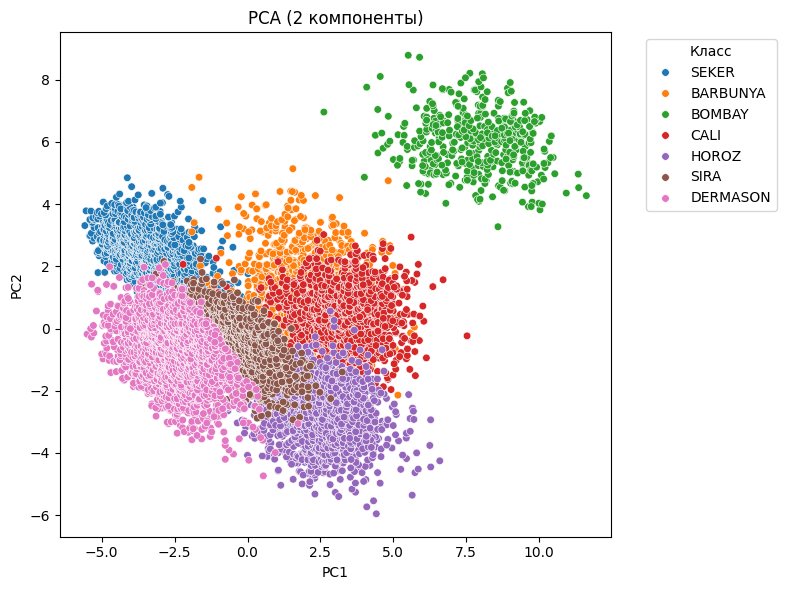

In [22]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Доля объяснённой дисперсии:",  pca.explained_variance_ratio_ ,
      "Суммарно:", sum(pca.explained_variance_ratio_))

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_labels, palette="tab10", s=30)
plt.title("PCA (2 компоненты)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Класс", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Датасет digits

Доля объяснённой дисперсии: [0.12033916 0.09561054] Суммарно: 0.21594970500832789


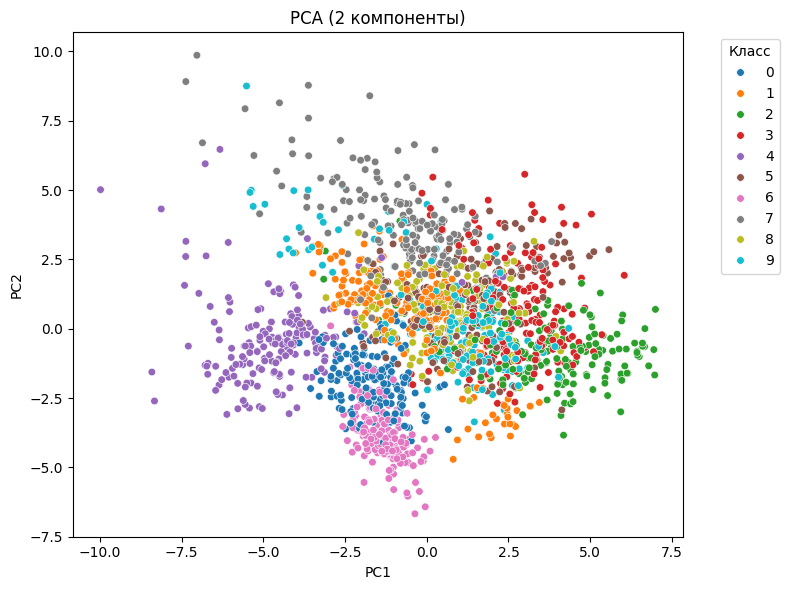

In [23]:
pca = PCA(n_components=2, random_state=42)
X_digits_pca = pca.fit_transform(X_digits_scaled)

print("Доля объяснённой дисперсии:",  pca.explained_variance_ratio_ ,
      "Суммарно:", sum(pca.explained_variance_ratio_))

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_digits_pca[:, 0], y=X_digits_pca[:, 1], hue=y_digits, palette="tab10", s=30)
plt.title("PCA (2 компоненты)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Класс", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

TSNE 2 компоненты

# Мой датасет

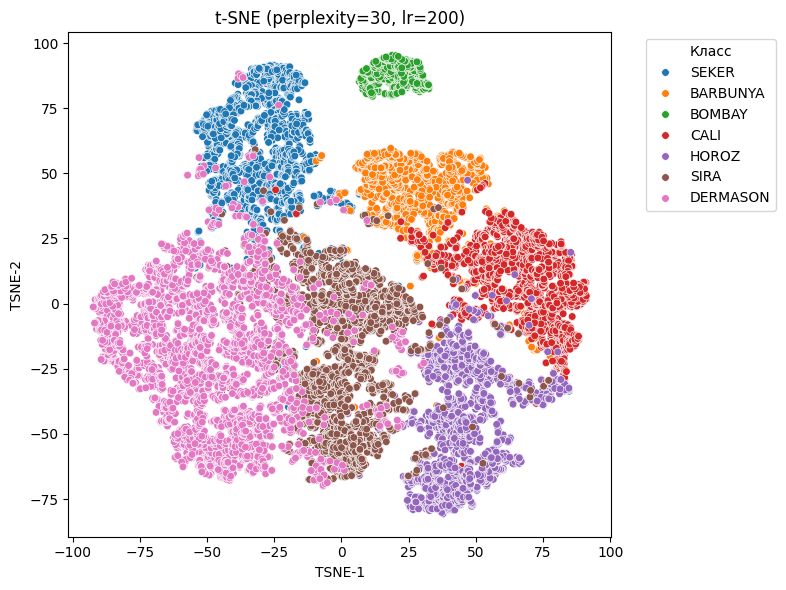

In [24]:
tsne = TSNE(
    n_components=2,
    random_state=42
)

X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_labels, palette="tab10", s=30)
plt.title("t-SNE (perplexity=30, lr=200)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend(title="Класс", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Датасет digits

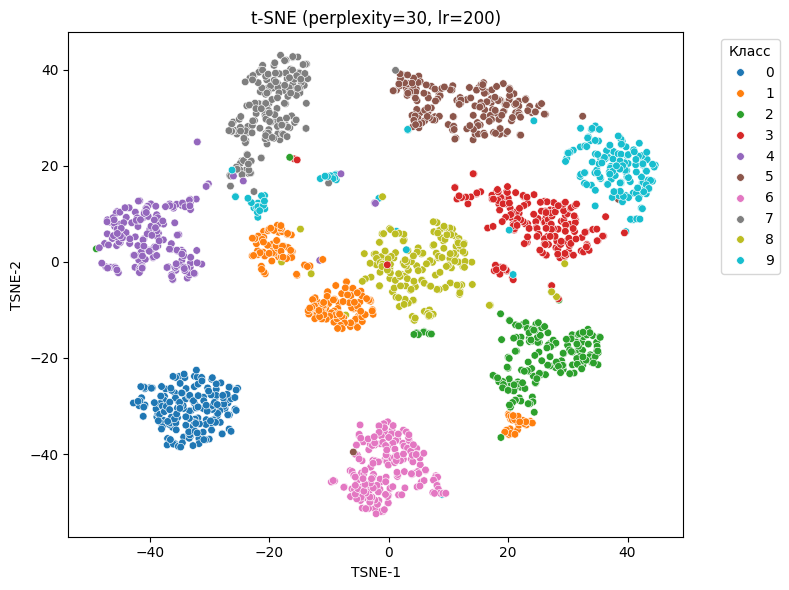

In [25]:
tsne = TSNE(
    n_components=2,
    random_state=42
)

X_digits_tsne = tsne.fit_transform(X_digits_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_digits_tsne[:, 0], y=X_digits_tsne[:, 1], hue=y_digits, palette="tab10", s=30)
plt.title("t-SNE (perplexity=30, lr=200)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend(title="Класс", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Мой датасет

In [26]:
from sklearn.metrics import pairwise_distances

def separation_score(X_2d, y):
    D = pairwise_distances(X_2d)
    same = D[y[:, None] == y[None, :]]
    diff = D[y[:, None] != y[None, :]]
    return same.mean(), diff.mean(), diff.mean() / same.mean()

pca_same, pca_diff, pca_ratio = separation_score(X_pca, y)
tsne_same, tsne_diff, tsne_ratio = separation_score(X_tsne, y)

print("PCA:  среднее расстояние внутри класса =", pca_same,
      ", между классами =", pca_diff,
      ", ratio =", pca_ratio)
print("t-SNE: среднее расстояние внутри класса =", tsne_same,
      ", между классами =", tsne_diff,
      ", ratio =", tsne_ratio)

PCA:  среднее расстояние внутри класса = 1.5636186066060855 , между классами = 4.942890012454883 , ratio = 3.1611864885540593
t-SNE: среднее расстояние внутри класса = 35.868195 , между классами = 87.34766 , ratio = 2.4352398


# Датасет digits

In [27]:
pca_same, pca_diff, pca_ratio = separation_score(X_digits_pca, y_digits)
tsne_same, tsne_diff, tsne_ratio = separation_score(X_digits_tsne, y_digits)

print("PCA:  среднее расстояние внутри класса =", pca_same,
      ", между классами =", pca_diff,
      ", ratio =", pca_ratio)
print("t-SNE: среднее расстояние внутри класса =", tsne_same,
      ", между классами =", tsne_diff,
      ", ratio =", tsne_ratio)

PCA:  среднее расстояние внутри класса = 2.4682343991638254 , между классами = 4.761456156687813 , ratio = 1.9290939945982732
t-SNE: среднее расстояние внутри класса = 12.113918 , между классами = 48.357334 , ratio = 3.991882


Вычислить и отрисовать T-SNE с разным значением Perplexity

# Мой датасет

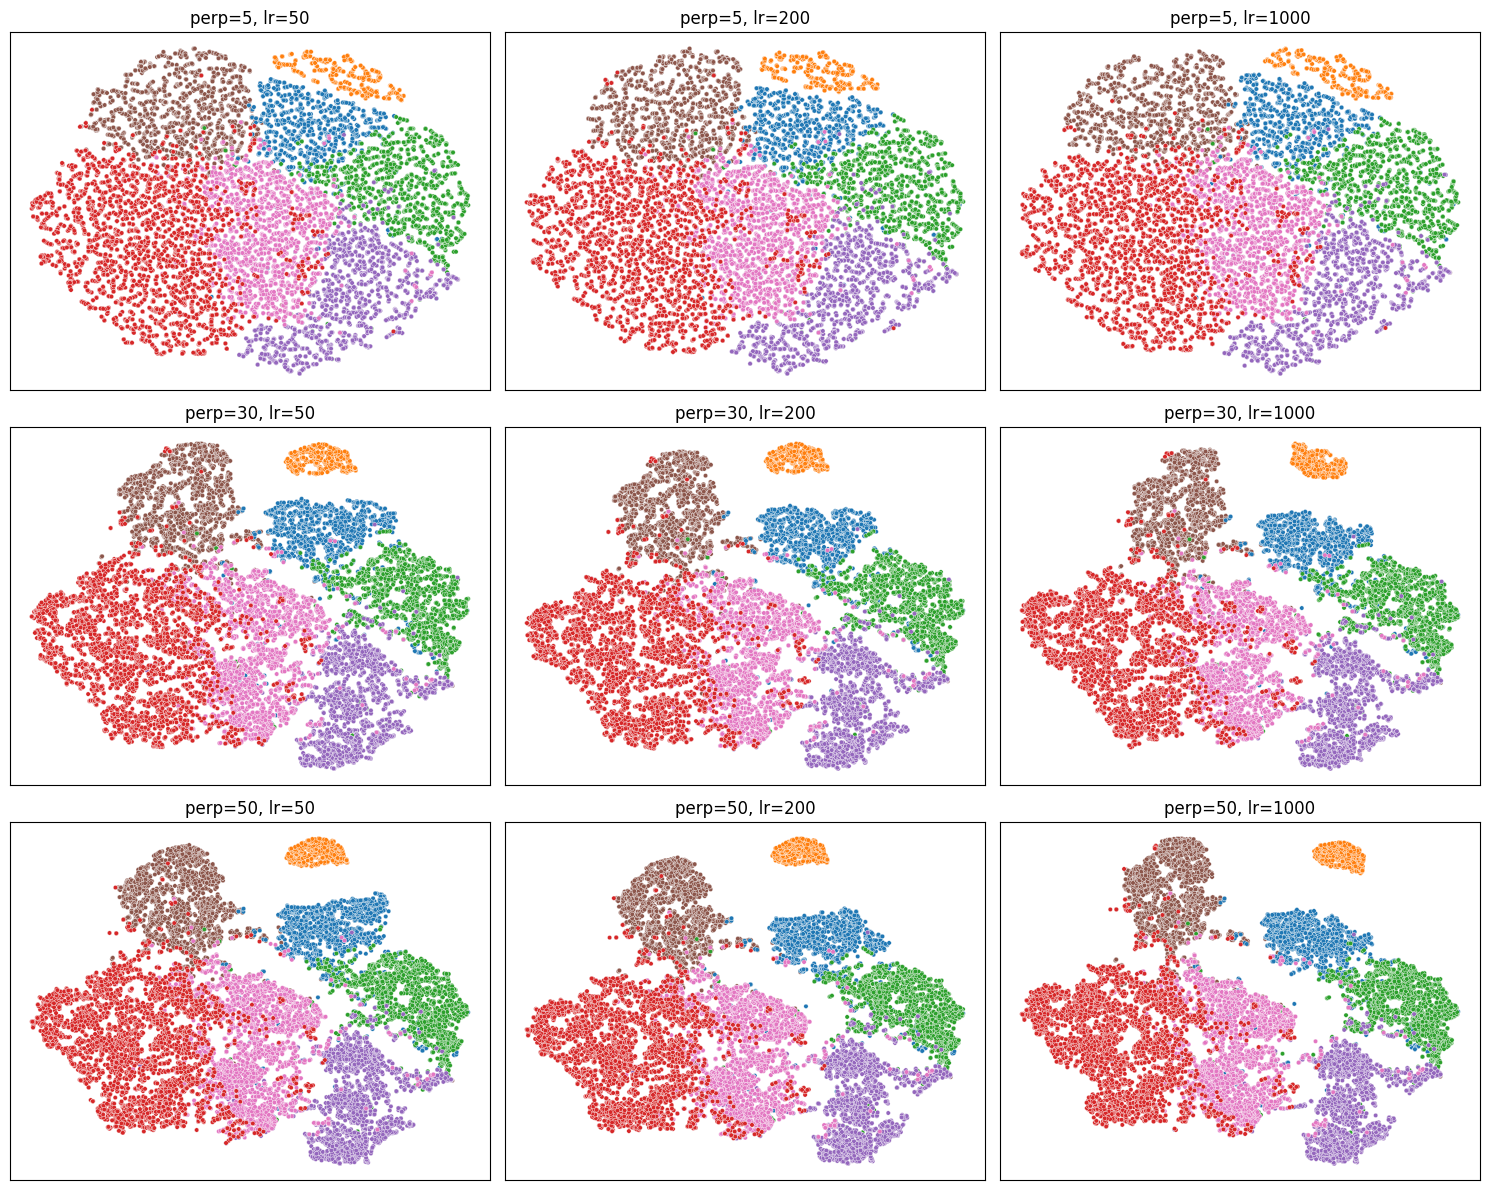

In [28]:
perplexities = [5, 30, 50]
learning_rates = [50, 200, 1000]

fig, axes = plt.subplots(len(perplexities), len(learning_rates),
                         figsize=(5*len(learning_rates), 4*len(perplexities)))

for i, perp in enumerate(perplexities):
    for j, lr in enumerate(learning_rates):
        tsne = TSNE(
            perplexity=perp,
            learning_rate=lr,
            random_state=42
        )
        X_emb = tsne.fit_transform(X_scaled)
        ax = axes[i, j]
        sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1],
                        hue=y, palette="tab10", s=10, ax=ax, legend=False)
        ax.set_title(f"perp={perp}, lr={lr}")
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

# Выводы:
* При больших параметрах perplexity кластеры разных классов бобов становятся более компактными и лучше разделяются
* При маленьких параметрах perplexity (5) кластеры дробятся на множество мелких подгрупп
* Параметр learning_rate при значениях 50 и 200 даёт схожие результаты, при 1000 — кластеры могут сжиматься или деформироваться
* Наиболее чёткое разделение 7 классов достигается при perplexity=30-50 и learning_rate=200

# Датасет digits

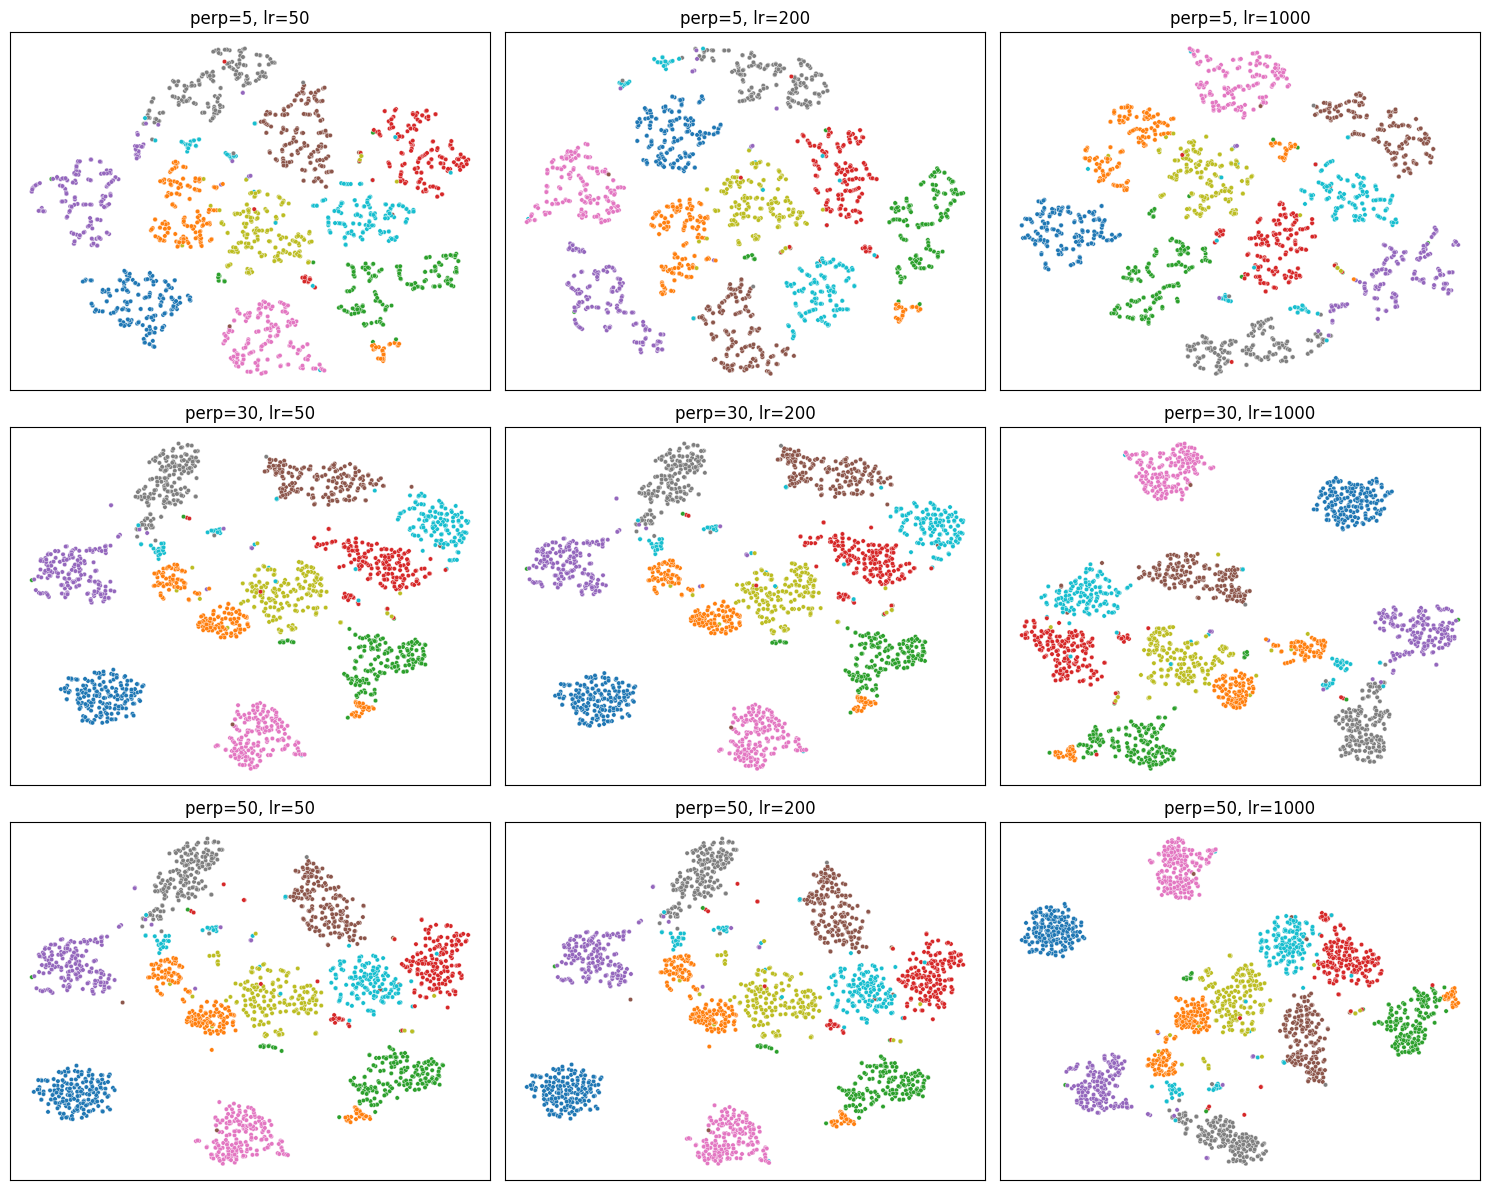

In [29]:
perplexities = [5, 30, 50]
learning_rates = [50, 200, 1000]

fig, axes = plt.subplots(len(perplexities), len(learning_rates),
                         figsize=(5*len(learning_rates), 4*len(perplexities)))

for i, perp in enumerate(perplexities):
    for j, lr in enumerate(learning_rates):
        tsne = TSNE(
            perplexity=perp,
            learning_rate=lr,
            random_state=42
        )
        X_emb = tsne.fit_transform(X_digits_scaled)
        ax = axes[i, j]
        sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1],
                        hue=y_digits, palette="tab10", s=10, ax=ax, legend=False)
        ax.set_title(f"perp={perp}, lr={lr}")
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

# Выводы:
* При маленьких значениях perplexity объекты в рамках одного кластера находятся далеко друг от друга
* Параметр learning_rate очень сильно влияет на итоговую картину кластеров, но только при больших значениях (разницы между 50 и 200 практически нет, только некоторые кластеры меняются местами).
* Увеличение параметров learning_rate и perplexity, даже по отдельности, заметно увеличивает расстояния между кластерами разных классов.

Проанализируйте:

как меняется форма кластеров,

возникают ли "разрывы" или слияния при разных параметрах,

насколько стабилен рисунок при небольших изменениях параметров.

PCA: устойчивая структура
Для PCA параметров немного (по сути только число компонент), проекция при фиксированном random_state практически не меняется, что показывает устойчивость метода.

Можно показать, что при разных n_components (2, 3, больше) первые две компоненты остаются близкими, а общая структура мало меняется.

In [30]:
N_COMPONENTS = np.linspace(2, 10, 9, dtype=int)
N_COMPONENTS

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])

# Мой датасет

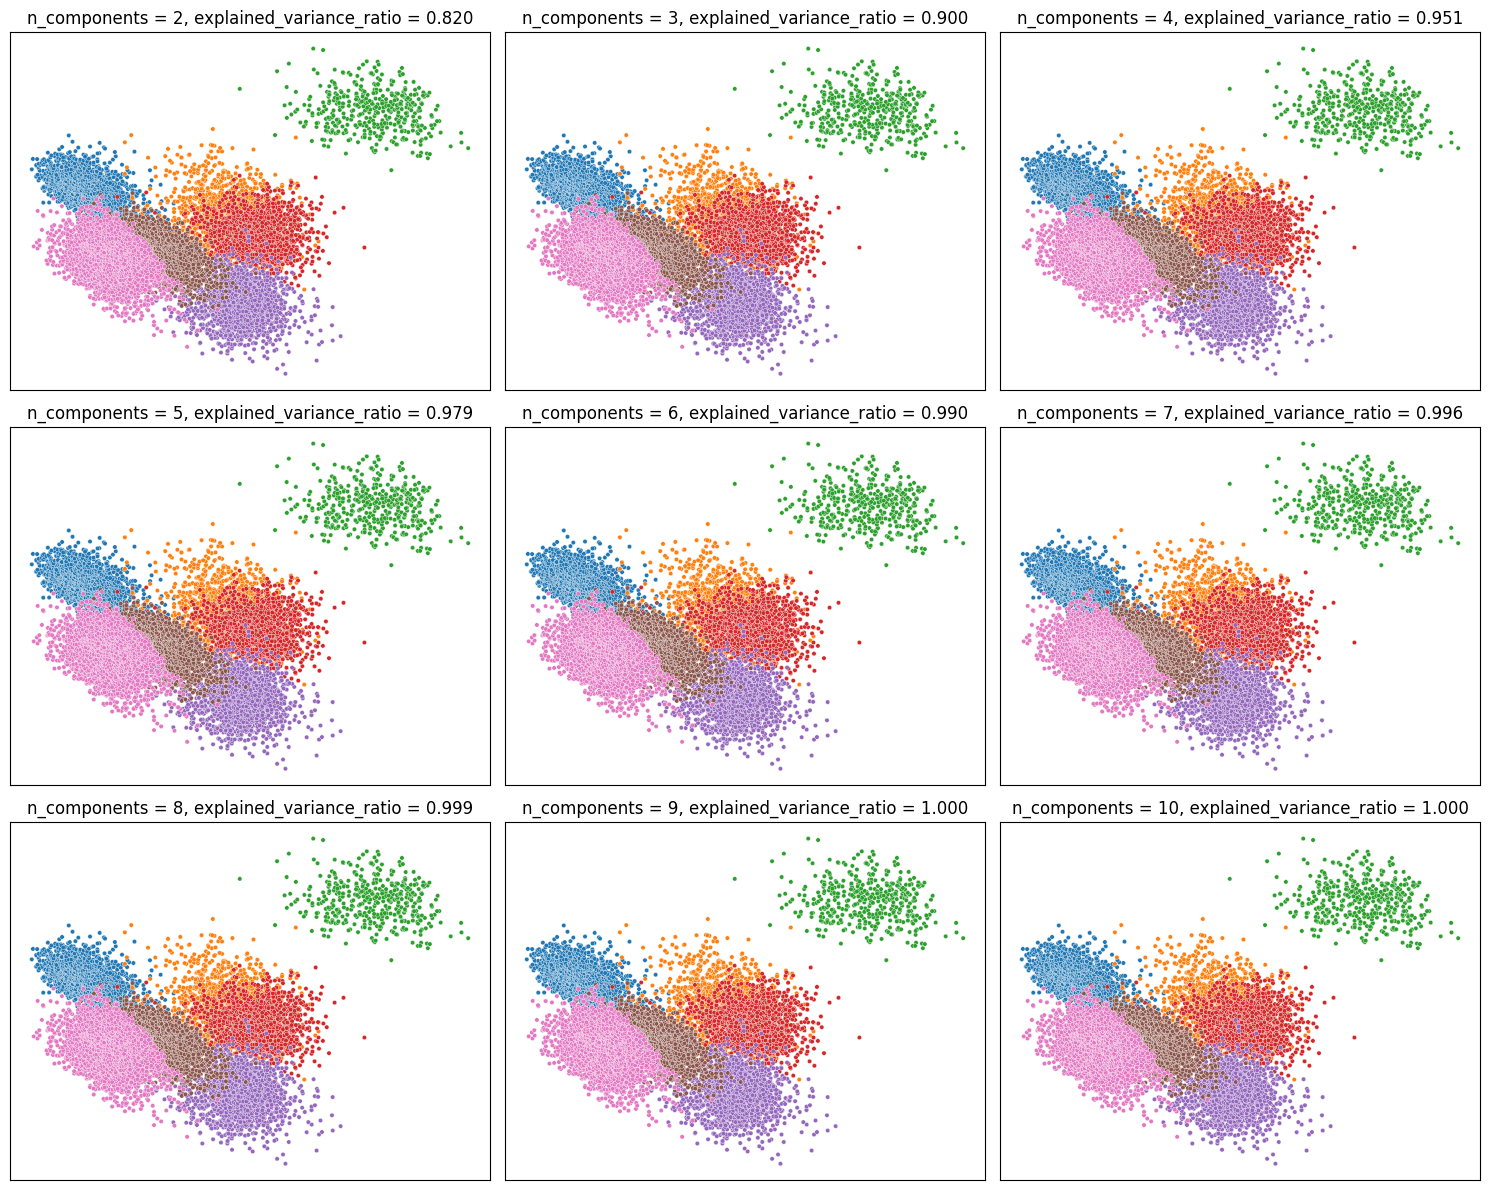

In [31]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for i, n_comp in enumerate(N_COMPONENTS):
    pca = PCA(n_components=n_comp, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    ax = axes[i // 3, i % 3]
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                    hue=y_labels, palette="tab10", s=10, ax=ax, legend=False)
    ax.set_title(f"n_components = {n_comp}, explained_variance_ratio = {pca.explained_variance_ratio_.sum():.3f}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

# Датасет digits

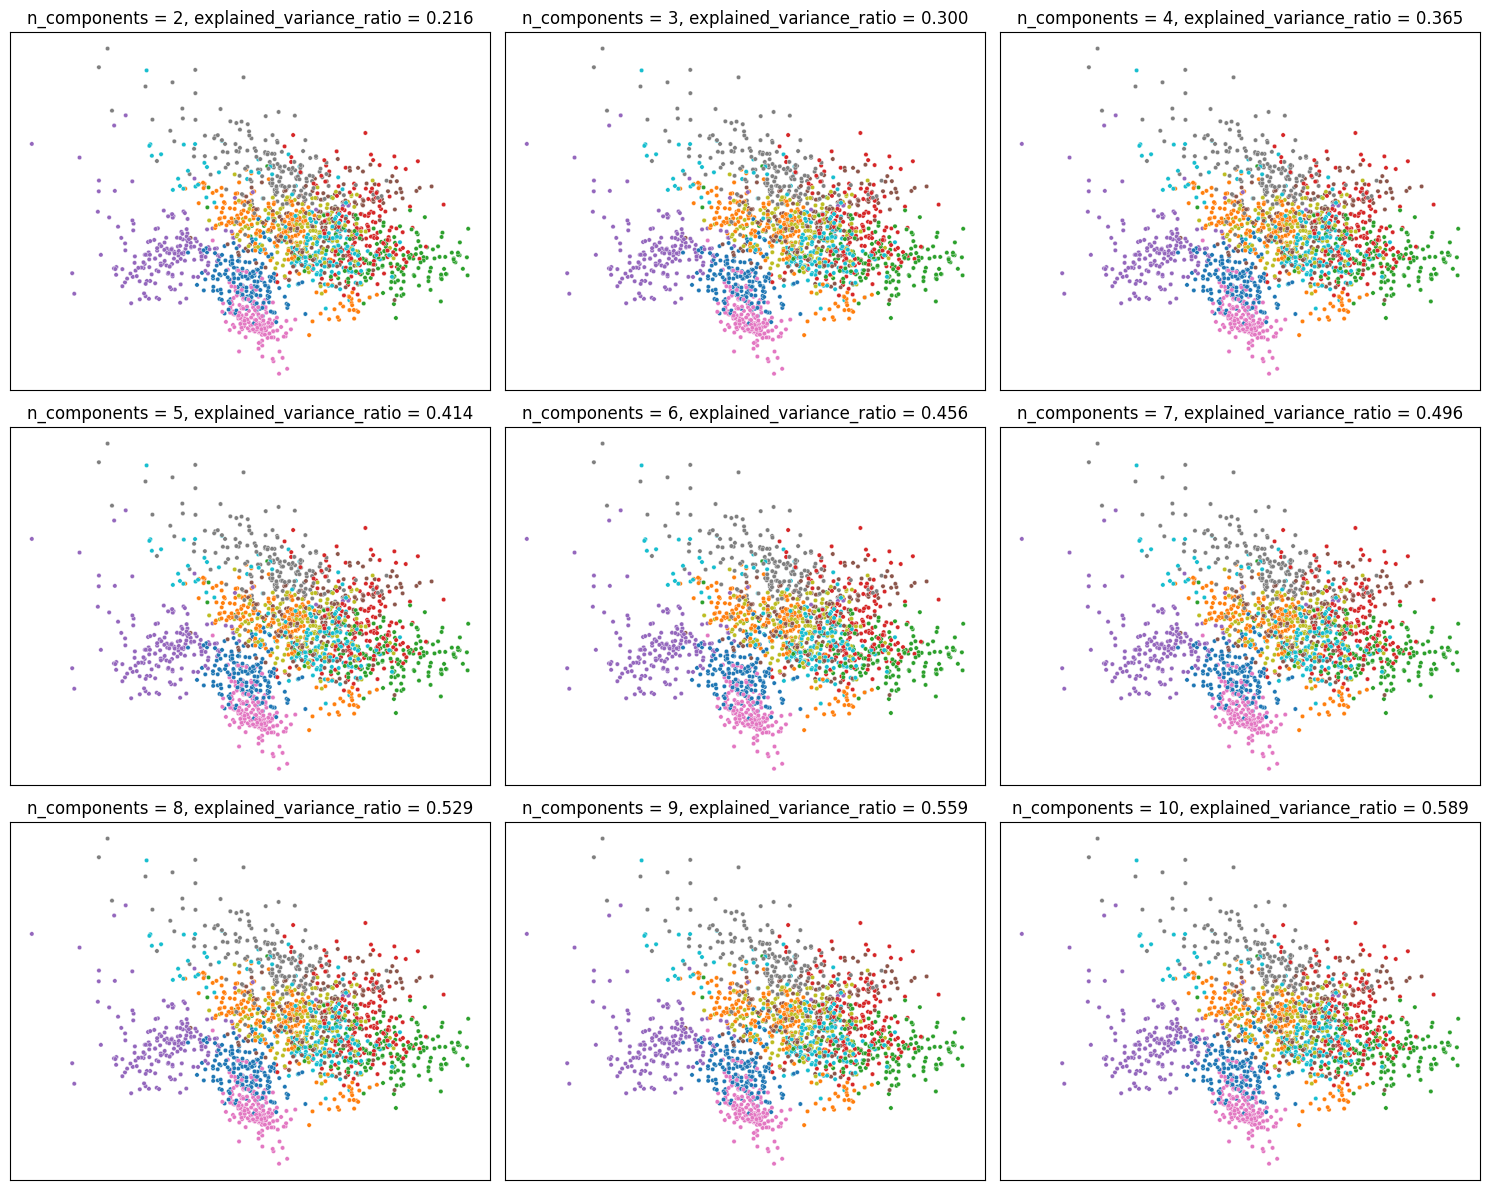

In [32]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for i, n_comp in enumerate(N_COMPONENTS):
    pca = PCA(n_components=n_comp, random_state=42)
    X_digits_pca = pca.fit_transform(X_digits_scaled)
    ax = axes[i // 3, i % 3]
    sns.scatterplot(x=X_digits_pca[:, 0], y=X_digits_pca[:, 1],
                    hue=y_digits, palette="tab10", s=10, ax=ax, legend=False)
    ax.set_title(f"n_components = {n_comp}, explained_variance_ratio = {pca.explained_variance_ratio_.sum():.3f}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()